## 1. Import libraries

In [2]:
import rasterio
import numpy as np
import random
import os
import torch
import pandas as pd
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

## 2. Config

In [117]:
config={
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'seed':10,
    'val_size':0.3,
    'channels':[6,5,2],
    'experiment':True,
    'batch_size':8,
    'lr':1e-3,
    'epochs':50,
    'early_stopping':15,
    'inference':{
        'threshold':0.8
    }
}
DATAPATH='./dataset'
data_paths={
    'train_csv': DATAPATH+'/train_meta_exp.csv',
    'test_csv': DATAPATH+'/test_meta_exp.csv',
    'train_img':DATAPATH+'/train_img/',
    'train_mask':DATAPATH+'/train_mask/',
    'test_img':DATAPATH+'/test_img/',
}
train_csv = pd.read_csv(data_paths['train_csv'])
SAVE_PATH = './logs'
save_paths={
    'model':SAVE_PATH+'/models/',
    'val':SAVE_PATH+'/vals/'
}
# 시드 고정 함수
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
fix_seed(config['seed'])

## 3. Load Data

In [104]:
class Wildfire_Dataset(Dataset):
    def __init__(self, csv, transform_f=None,infer=False):
        self.csv = csv
        self.transform_f = transform_f
        self.infer = infer
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self,idx):
        img_path = self.csv.iloc[idx,0]
        # test인 경우 infer==True
        if self.infer:
            image = rasterio.open(data_paths['test_img']+img_path).read().transpose(1,2,0)[:,:,config['channels']]
            image = image/(2**16)
            if self.transform_f:
                image = self.transform_f(image=image)['image']
            return image
        # train인 경우
        image = rasterio.open(data_paths['train_img']+img_path).read().transpose(1,2,0)[:,:,config['channels']]
        image = image/(2**16)
        mask_path = self.csv.iloc[idx,1]
        mask = rasterio.open(data_paths['train_mask']+mask_path).read().transpose(1,2,0)
        if self.transform_f:
            augmented = self.transform_f(image=image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask

In [74]:
base_transforms = {
    'train': A.Compose([
        # A.RandomBrightnessContrast(contrast_limit=(2,2),p=1),
        A.Normalize((0.5, ), (0.5, )),
        ToTensorV2(transpose_mask=True)
    ]),
    'valid':A.Compose([
        A.Normalize((0.5, ), (0.5, )),
        ToTensorV2(transpose_mask=True)
    ]),
    'test':A.Compose([
        A.Normalize((0.5, ), (0.5, )),      
        ToTensorV2(transpose_mask=True)
    ]),
}

In [80]:
fix_seed(config['seed'])
train_csv_, valid_csv_ = train_test_split(train_csv,test_size=config['val_size'],random_state=config['seed'])
train_dataset = Wildfire_Dataset(train_csv_,transform_f=base_transforms['train'],infer=False)
valid_dataset = Wildfire_Dataset(valid_csv_,transform_f=base_transforms['valid'],infer=False)
# B,C,H,W

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'],shuffle=False)
print(f'train size: {len(train_dataset)}, valid size: {len(valid_dataset)}')

train size: 14, valid size: 6


Augmentation Result Viewer

torch.Size([8, 3, 256, 256])


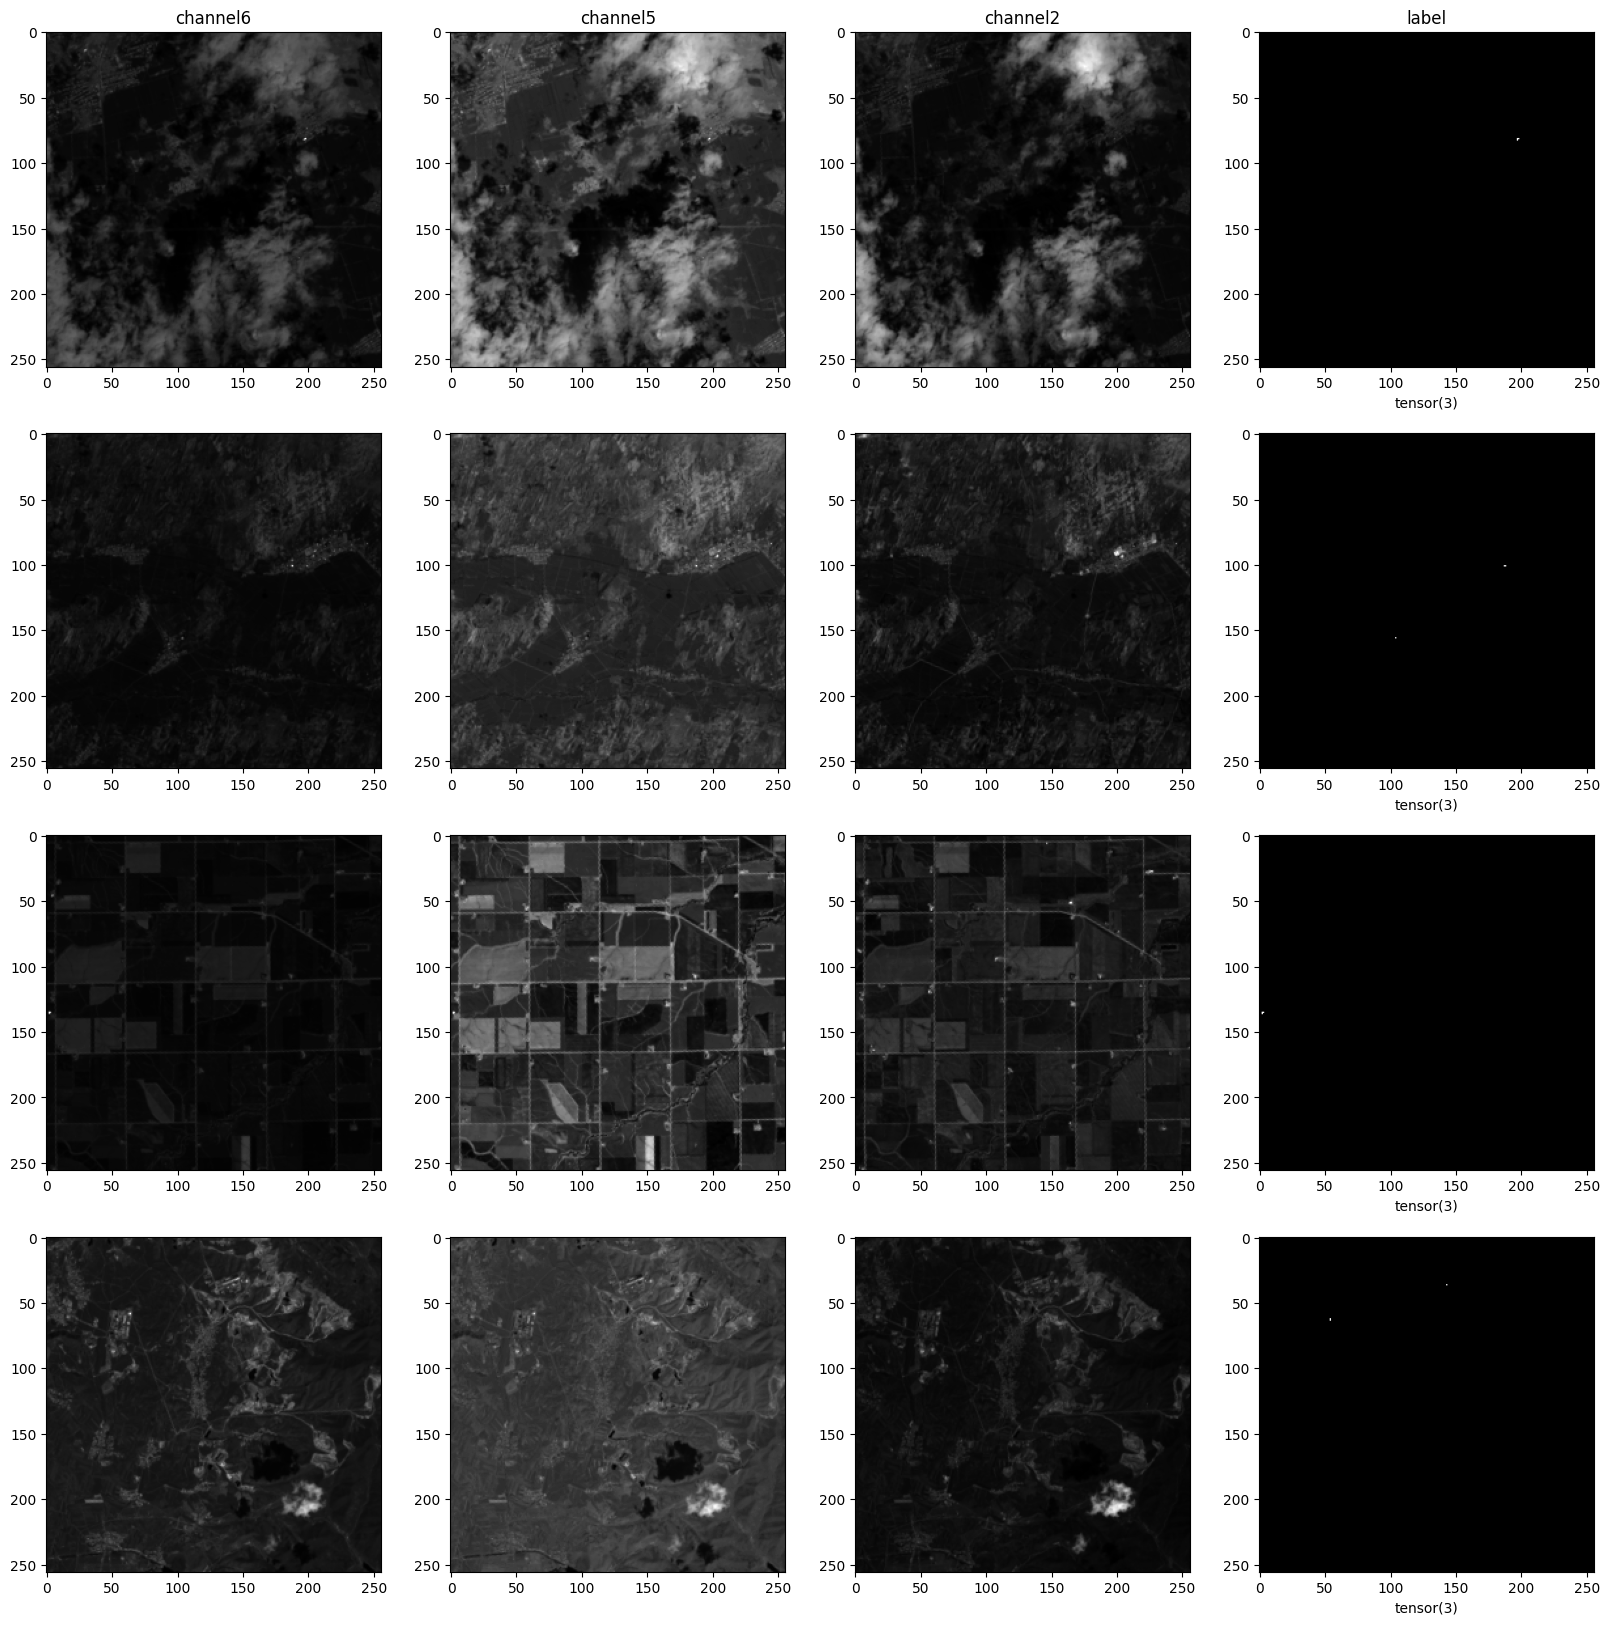

In [124]:
num_imgs_to_show=4
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('label')

cnt=0
for idx,(imgs, masks) in enumerate(train_loader):
    print(imgs.shape)
    for i in range(len(imgs)):
        for j in range(len(config['channels'])):
            axs[i,j].imshow(imgs[i,j,:,:],cmap='gray')
        axs[i,-1].imshow(masks[i,0,:,:],cmap='gray')
        axs[i,-1].set_xlabel(str(masks[i,0,:,:].sum().sum()))
        cnt+=1
        if cnt==num_imgs_to_show:
            break
    if cnt==num_imgs_to_show:
        break

## 4. Modeling

In [83]:
import segmentation_models_pytorch as smp

C:\Users\artis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [88]:
model = smp.Unet(
    encoder_name='efficientnet-b0',
    encoder_weights = 'imagenet',
    in_channels=len(config['channels']),
    classes=1,
)
torch.save(model.state_dict(), save_paths["model"]+'/base_model.pt')

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets, reduction='none')

        pt = torch.exp(-ce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## 5. Train/Validation

In [89]:
def validation(config, model, criterion, valid_loader,epoch):
    model.eval()
    valid_loss=0
    y_pred_dict={}
    with torch.no_grad():
        for idx,(images, masks) in tqdm(enumerate(valid_loader)):
            images = images.to(config['device'],dtype = torch.float32)
            masks = masks.to(config['device'],dtype = torch.float32)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            valid_loss +=loss.item()
            
            for i in range(len(outputs)):
                y_pred = np.where(outputs[i,0,:,:]>config['inference']['threshold'],1,0).astype(np.uint8)
                y_pred_dict[str(idx*config['batch_size']+i)] = y_pred
        valid_save_path = save_paths['val']+f'epoch_{epoch}.pkl'
        joblib.dump(y_pred_dict,valid_save_path)
    return valid_loss/len(valid_loader)

In [90]:
def train(config, model, train_loader, valid_loader):
    model = model.to(config['device'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None
    
    criterion = FocalLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = config['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-8, verbose=True)
    print('***TRAINING START***')
    for epoch in range(config['epochs']):
        model.train()
        epoch_loss=0
        for images, masks in tqdm(train_loader):
            images = images.to(config['device'],dtype = torch.float32)
            masks = masks.to(config['device'],dtype = torch.float32)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            epoch_loss+=loss.item()
        
        val_loss = validation(config, model, criterion, valid_loader, epoch)
        
        es_count += 1
        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = model
            state_dict = model.state_dict()
            best_epoch = epoch+1
            print(f"Epoch [{best_epoch}] New Minimum Valid Loss!")
            print("..save current best model..")
            model_name = f'epoch {epoch}_current_best_model.pt'
            torch.save(state_dict, save_paths['model']+'/'+model_name)
        
        scheduler.step(val_loss)
        
        if es_count == config['early_stopping']:
            print(f"Early Stopping Count에 도달했습니다!")
            print(f"Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f}, Best Epoch: {best_epoch}")
            print("***TRAINING DONE***")
            return best_model
        print(f"Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f}, ES Count: {es_count}")
        print("------------------------------------------------------------------------------------")
    print(f"Early Stopping Count에 도달하지 않았습니다! \nEarly Stopping Count: {config['early_stopping']} Best Epoch: {best_epoch}")
    print("***TRAINING DONE***")
    return best_model

In [ ]:
best_model = train(config,model,train_loader,valid_loader)

## 6. Inference

In [94]:
model = smp.Unet(
    encoder_name='efficientnet-b0',
    encoder_weights = 'imagenet',
    in_channels=len(config['channels']),
    classes=1,
)
model.load_state_dict(torch.load('./logs/models/epoch 17_current_best_model.pt'))

<All keys matched successfully>

In [139]:
test_csv = pd.read_csv(data_paths['test_csv'])
test_dataset = Wildfire_Dataset(test_csv,transform_f=base_transforms['test'],infer=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [140]:
y_pred_dict = {}

for idx,img in tqdm(enumerate(test_loader)):
    y_pred = model.predict(img)

    y_pred = np.where(y_pred[0, 0, :, :] > 0.25, 1, 0) # 임계값 처리
    y_pred = y_pred.astype(np.uint8)
    y_pred_dict[idx] = y_pred

joblib.dump(y_pred_dict, './y_pred.pkl')

20it [00:02,  7.53it/s]


['./y_pred.pkl']

## 7. Validation Viewer

In [126]:
epoch_to_check = 17
num_imgs_to_show = 4
valid_save_path = save_paths['val']+f'epoch_{epoch_to_check}.pkl'
val_preds = joblib.load(valid_save_path)

torch.Size([8, 3, 256, 256])


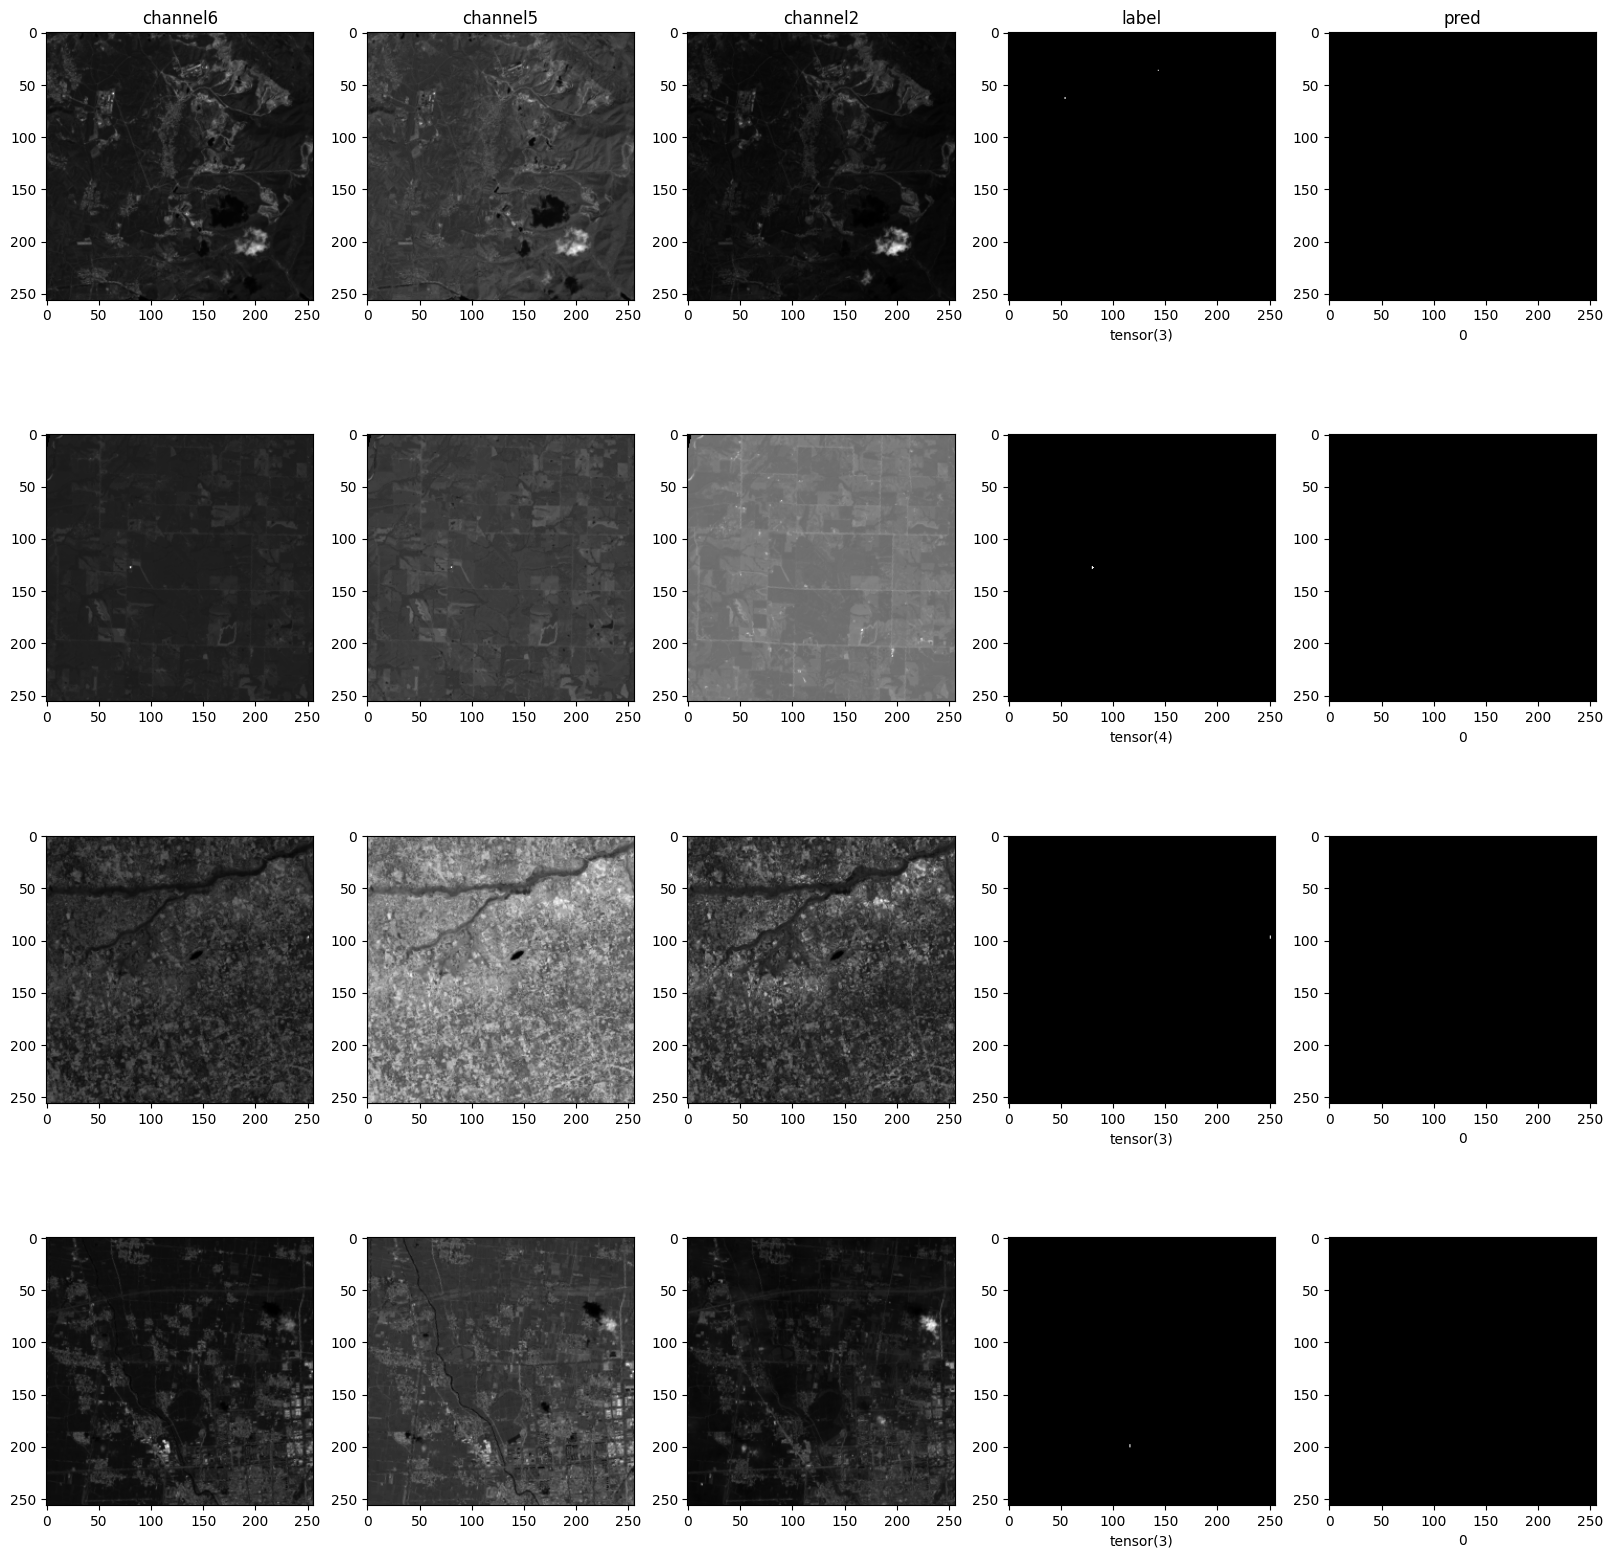

In [127]:
val_preds = joblib.load(valid_save_path)
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+2)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('label')
axs[0,i+2].set_title('pred')
cnt=0
for idx,(imgs, masks) in enumerate(train_loader):
    print(imgs.shape)
    for i in range(len(imgs)):
        for j in range(len(config['channels'])):
            axs[i,j].imshow(imgs[i,j,:,:],cmap='gray')
        axs[i,-2].imshow(masks[i,0,:,:],cmap='gray')
        axs[i,-2].set_xlabel(str(masks[i,0,:,:].sum().sum()))
        axs[i,4].imshow(val_preds[str(idx*config['batch_size']+i)],cmap='gray')
        axs[i,4].set_xlabel(str(val_preds[str(idx*config['batch_size']+i)].sum().sum()))
        cnt+=1
        if cnt==num_imgs_to_show:
            break
    if cnt==num_imgs_to_show:
        break

## 8. Inference Viewer

In [141]:
num_imgs_to_show = 4
test_save_path = './y_pred.pkl'
test_preds = joblib.load(test_save_path)

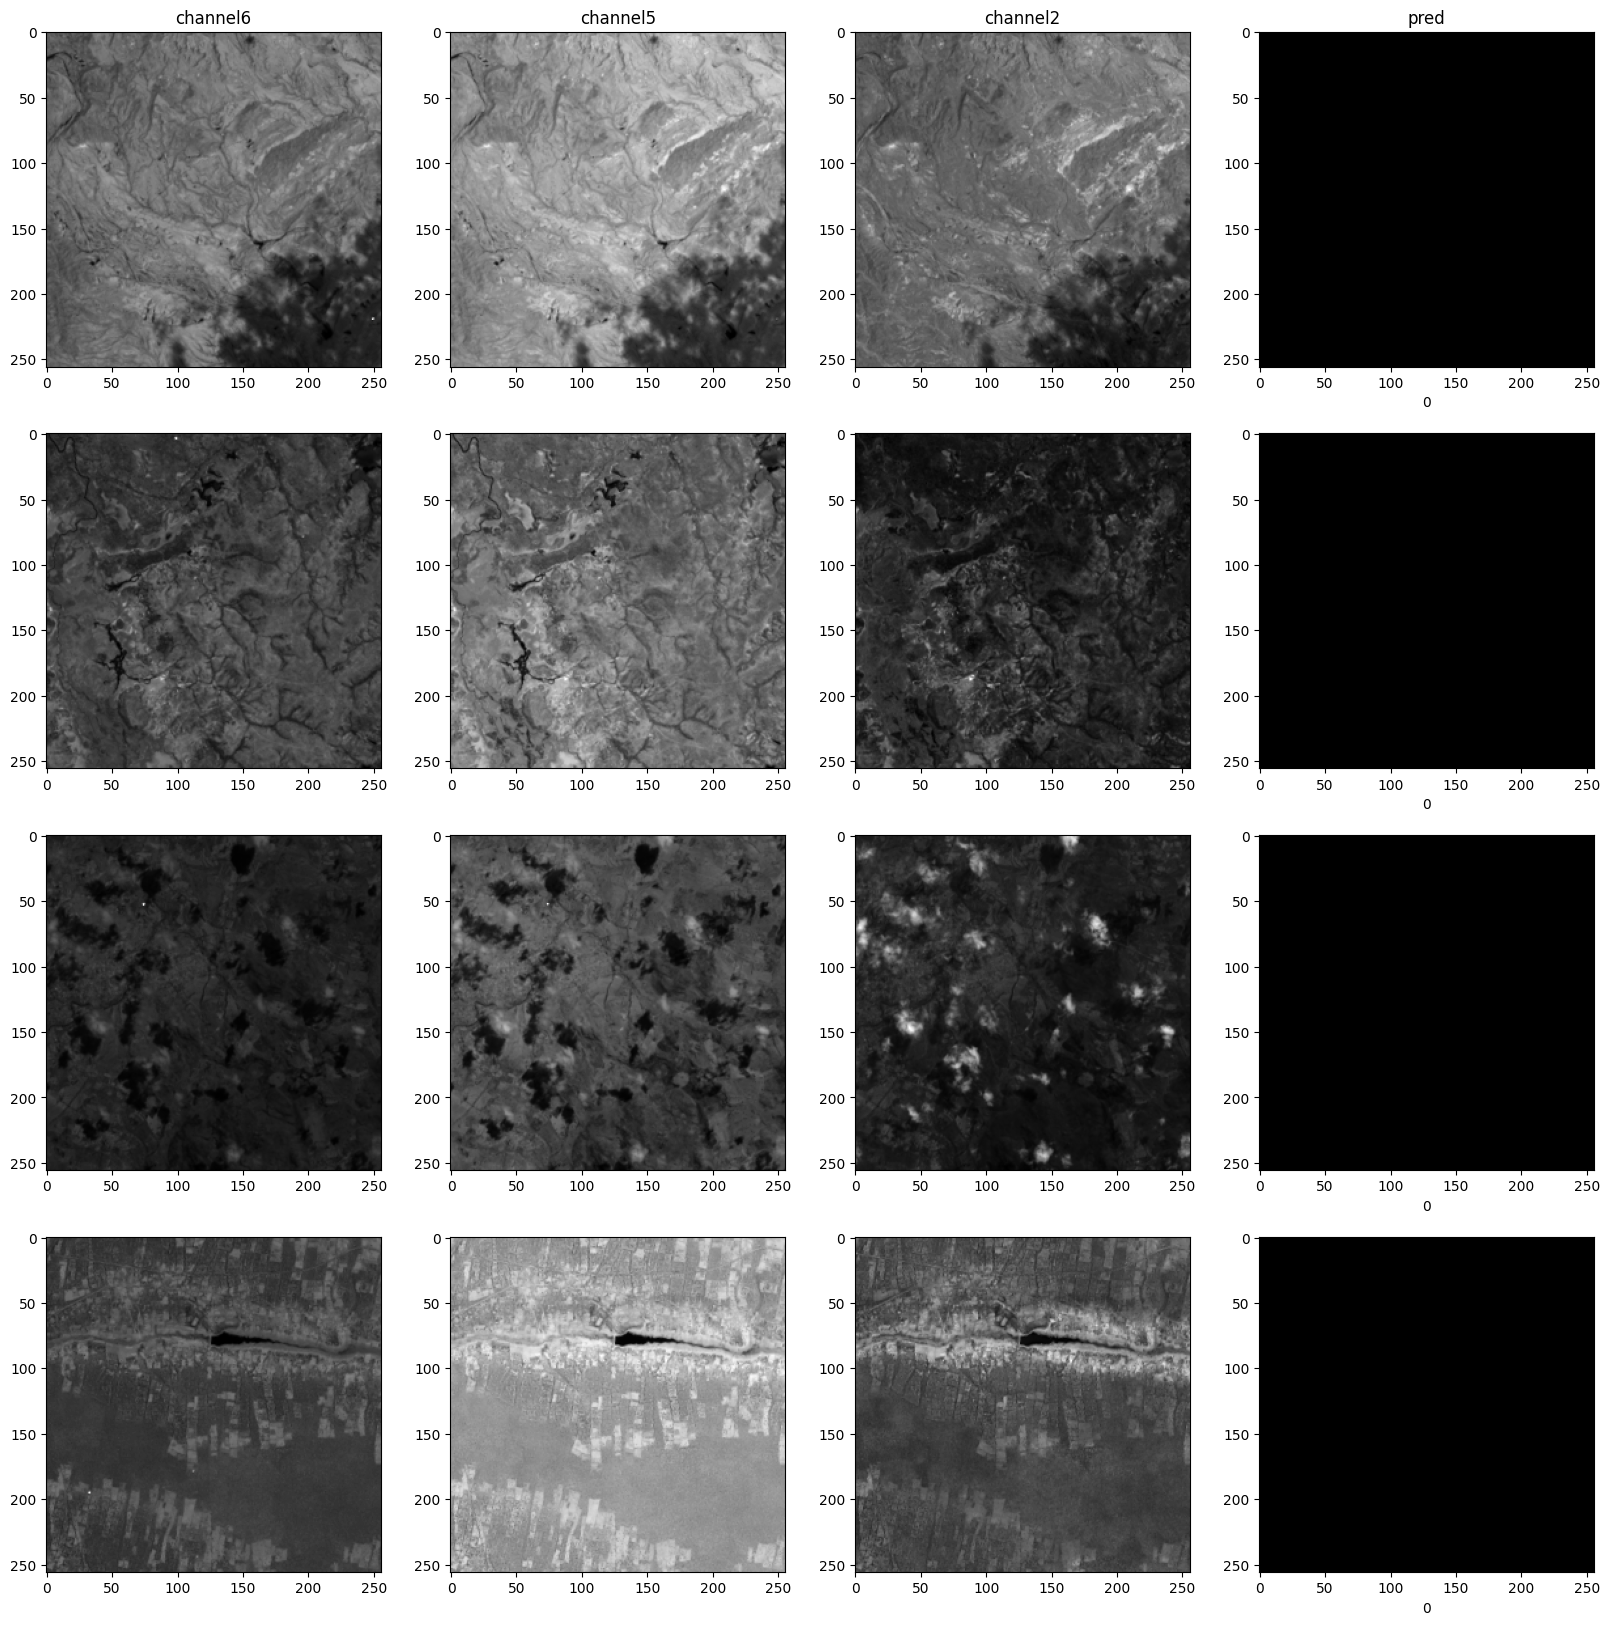

In [143]:
test_preds = joblib.load(test_save_path)
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('pred')
cnt=0
for (imgs) in (test_loader):
    for j in range(len(config['channels'])):
        axs[cnt,j].imshow(imgs[0,j,:,:],cmap='gray')
    axs[cnt,-1].imshow(test_preds[cnt],cmap='gray')
    axs[cnt,-1].set_xlabel(str(test_preds[cnt].sum().sum()))
    cnt+=1
    if cnt==num_imgs_to_show:
        break